In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [30]:
def composites_doy(var): 
    if var == 'dic_stf_gas':
        var_folder = 'f_dic'
    elif var == 'o2_stf_gas':
        var_folder = 'f_o2'
    else:
        var_folder = var

    ds = xr.open_dataset(f'/work/Katherine.Turner/tempest-extremes/odiv-251/comp_{var_folder}/comp_{var}_anom.nc', use_cftime=True)
    
    test = ds[f'snap_{var}_anom']
    test = xr.where(abs(test)>1e10, np.nan, test)
    test = xr.where(test==0, np.nan, test)

    X = np.meshgrid(ds.x.data,ds.y.data)
    mask = xr.DataArray(np.sqrt(X[0]**2 + X[1]**2) <= 10, dims=['x', 'y'])
    masked_var = xr.where(mask, test, np.nan)

    # subsample for periods that we have ocean output (daily, timestamp is 12:00:00)

    ds.snap_time.dt.hour == 12
    time = ds.snap_time[ds.snap_time.dt.hour == 12]
    snap = ds.snapshot[ds.snap_time.dt.hour == 12]

    flux = masked_var[:,:,ds.snap_time.dt.hour == 12]

    # create a dataset to group snapshots by day of year

    ds_masked = ds = xr.Dataset(
        data_vars=dict(
            flux=(["x", "y", "snapshot"], flux.data),
            time=(["snapshot"], time.data),
        ),
        coords=dict(
            x=ds.x.data,
            y=ds.y.data,
            snapshot=snap.data,
        ),
        attrs=dict(description=f"{var} snapshots"),
    )

    flux_avg_tot = flux.mean(dim="snapshot")
    flux_avg_doy = ds_masked.flux.groupby(time.dt.dayofyear).mean(skipna=True)
    
    return flux_avg_tot, flux_avg_doy

In [35]:
o2_tot, o2_doy = composites_doy('o2_stf_gas')
dic_tot, dic_doy = composites_doy('dic_stf_gas')

hfds_tot, hfds_doy = composites_doy('hfds')

In [53]:
r = 10 * 111e3
dx = 0.5 * 111e3
dt = 24 * 60**2

avg_stormdays_yr = time.groupby(time.dt.year).count()
avg_storms_day = time.groupby(time.dt.dayofyear).count() / 95

# using seasonal cycle of the storm-centered anomalies, create a daily climatology
hfds_ann_cycle_1 = np.pi * r**2 * hfds_tot.mean(dim={"x", "y"}, skipna=True) * avg_storms_day
hfds_ann_cycle_2 = np.pi * r**2 * hfds_doy.mean(dim={"x", "y"}, skipna=True) * avg_storms_day

dic_ann_cycle_1 = np.pi * r**2 * dic_tot.mean(dim={"x", "y"}, skipna=True) * avg_storms_day * 24 * 60**2 * 12.011
dic_ann_cycle_2 = np.pi * r**2 * dic_doy.mean(dim={"x", "y"}, skipna=True) * avg_storms_day * 24 * 60**2 * 12.011 


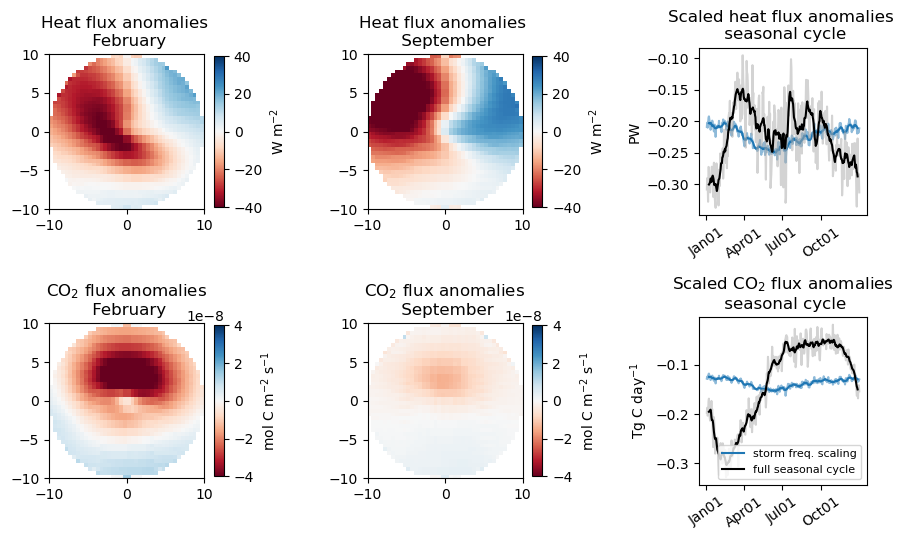

In [91]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(9,5.5))
axs=axs.flatten()

hfds_doy[:,:,31:59].mean('dayofyear').plot(y='y', ax=axs[0], vmin=-40, vmax=40, extend='neither', cmap=plt.get_cmap('RdBu'),
                                              cbar_kwargs={"aspect":15, "shrink":0.9, "label":"W m$^{-2}$"})

hfds_doy[:,:,242:273].mean('dayofyear').plot(y='y', ax=axs[1], vmin=-40, vmax=40, extend='neither', cmap=plt.get_cmap('RdBu'),
                                                cbar_kwargs={"aspect":15, "shrink":0.9, "label":"W m$^{-2}$"})

(1e-15*hfds_ann_cycle_1).plot(ax=axs[2], alpha=0.5)
(1e-15*hfds_ann_cycle_1).rolling(dayofyear=10, center=True).mean().plot(ax=axs[2], color='#1f77b4')
(1e-15*hfds_ann_cycle_2).plot(ax=axs[2], color='darkgrey', alpha=0.5)
(1e-15*hfds_ann_cycle_2).rolling(dayofyear=10, center=True).mean().plot(ax=axs[2], color='black')

dic_doy[:,:,31:59].mean('dayofyear').plot(y='y', ax=axs[3], vmin=-4e-8, vmax=4e-8, extend='neither', cmap=plt.get_cmap('RdBu'),
                                              cbar_kwargs={"aspect":15, "shrink":0.9, "label":"mol C m$^{-2}$ s$^{-1}$"})

dic_doy[:,:,242:273].mean('dayofyear').plot(y='y', ax=axs[4], vmin=-4e-8, vmax=4e-8, extend='neither', cmap=plt.get_cmap('RdBu'),
                                                cbar_kwargs={"aspect":15, "shrink":0.9, "label":"mol C m$^{-2}$ s$^{-1}$"})

(1e-12 * dic_ann_cycle_1).plot(ax=axs[5], alpha=0.5)
(1e-12 * dic_ann_cycle_1).rolling(dayofyear=10, center=True).mean().plot(ax=axs[5], color='#1f77b4', label="storm freq. scaling")
(1e-12 * dic_ann_cycle_2).plot(ax=axs[5], color='darkgrey', alpha=0.5)
(1e-12 * dic_ann_cycle_2).rolling(dayofyear=10, center=True).mean().plot(ax=axs[5], color='black', label="full seasonal cycle")
axs[5].legend(fontsize=8)

titles = ["Heat flux anomalies \n February", 
          "Heat flux anomalies \n September", 
          "Scaled heat flux anomalies \n seasonal cycle",
          "CO$_2$ flux anomalies \n February",
          "CO$_2$ flux anomalies \n September",
          "Scaled CO$_2$ flux anomalies \n seasonal cycle"]

for i in np.arange(6):
    axs[i].set_box_aspect(1)
    axs[i].set_ylabel('')
    axs[i].set_xlabel('')
    axs[i].set_title(titles[i])
    
axs[2].set_ylabel('PW')
axs[5].set_ylabel('Tg C day$^{-1}$')

for i in [2,5]:
    axs[i].set_xticks([0, 90, 181, 273])
    axs[i].set_xticklabels(['Jan01', 'Apr01', 'Jul01', 'Oct01'])
    axs[i].tick_params(axis='x', rotation=35)

plt.tight_layout()
plt.savefig("/work/Katherine.Turner/CM4_storms/analysis_figures/CM4_seasonal_composites.png", dpi=100, format="png", bbox_inches="tight")